In [2]:
import pandas as pd
import numpy as np
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import math


# Read the data into a pandas DataFrame

path = '/Users/jerzybala/Desktop/Simulation Experiments Aug-Sep 2023/PROCESSED_FOOD_Dec2023.csv'
df_org = pd.read_csv(path)

print(df_org.shape)
#df_org.columns.tolist()

# Calculate the original distribution
original_distribution = df_org['Processed food in diet'].value_counts()
print(original_distribution,"\n")



region_mapping = {
    'Anglosphere': ['United States', 'Canada', 'United Kingdom', 'Ireland', 'New Zealand', 'Australia'],
    'Latin America': ['Argentina', 'Chile', 'Colombia', 'Ecuador', 'Guatemala', 'Mexico', 'Peru', 'Puerto Rico', 'Venezuela', 'Brazil', 'Bolivia', 'Paraguay', 'Uruguay'],
    'Middle East': ['Iraq', 'Saudi Arabia', 'United Arab Emirates', 'Yemen', 'Iran', 'Israel', 'Jordan', 'Kuwait', 'Lebanon', 'Oman', 'Qatar', 'Syria', 'Bahrain'],
    'French & Spanish Speaking Mainland Europe': ['Spain', 'France', 'Belgium', 'Switzerland', 'Portugal', 'Italy', 'Greece', 'Germany', 'Austria', 'Netherlands'],
    'West Africa': ['Cameroon', 'Cote d’Ivoire', 'Democratic Republic of the Congo', 'Nigeria', 'Ghana', 'Senegal', 'Mali', 'Niger', 'Guinea'],
    'North Africa': ['Algeria', 'Egypt', 'Morocco', 'Tunisia', 'Libya', 'Sudan'],
    'East & Southeast Asia': ['China', 'Japan', 'South Korea', 'North Korea', 'Vietnam', 'Thailand', 'Malaysia', 'Indonesia', 'Philippines', 'Singapore'],
    'South Asia': ['India', 'Pakistan', 'Bangladesh', 'Sri Lanka', 'Nepal', 'Bhutan'],
    'Eastern Europe & Central Asia': ['Russia', 'Ukraine', 'Belarus', 'Moldova', 'Armenia', 'Azerbaijan', 'Georgia', 'Kazakhstan', 'Uzbekistan', 'Turkmenistan', 'Kyrgyzstan', 'Tajikistan'],
    'Scandinavia & Baltic': ['Sweden', 'Norway', 'Finland', 'Denmark', 'Iceland', 'Estonia', 'Latvia', 'Lithuania'],
    'Oceania & Pacific Islands': ['Fiji', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga'],
    'Sub-Saharan Africa': ['Kenya', 'Uganda', 'Tanzania', 'Rwanda', 'Burundi', 'South Africa', 'Zimbabwe', 'Zambia', 'Botswana', 'Namibia', 'Mozambique', 'Madagascar'],
    'Central America & Caribbean': ['Cuba', 'Dominican Republic', 'Haiti', 'Jamaica', 'Trinidad and Tobago', 'Barbados', 'Saint Lucia', 'Grenada', 'Belize', 'Costa Rica', 'El Salvador', 'Honduras', 'Nicaragua', 'Panama']
    # ... You can continue to add more regions and countries as needed.
}


# Invert the region mapping
country_to_region = {country: region for region, countries in region_mapping.items() for country in countries}

# Map each country to its region
df_org['Region'] = df_org['Country'].map(country_to_region)

# Now 'data' has an additional column 'Region' which indicates the region of each country



set1 = [
 'Overall MHQ',
 'MHQ_Sign',
 
 'Age',
 'Biological Sex',
#  'Different gender from biological sex',
#  'Gender Identity',
#  'Ethnicity',
 'Country',
#  'State',
#  'Place of living',
#  'City',
 'Education',
 'Employment',#  Yes
 'Region',
#  'Profession/Employment Sector',
 
 'Frequency of getting a good nights sleep',
 'Frequency of doing exercise',
 'Processed food in diet',
 'Frequency of Socializing',
 
#  'Number of Children',
#  'Household Size',
#  'Number of Siblings when growing up',
#  'Number of Close Friends',
 
#  'Description of Household Growing up',
#  'Relationship with Adult Family',
#  'Spirituality connection',
#  'Feelings of love towards others',
#  'Particular religion identity',
#  'Religion practice',

# smartphone with age<24
 
#  'Smartphone allowed in school',
#  'Smartphone use in lessons',
#  'Age of first social media account',
#  'Frequency of social media posting',
#  'Tablet ownership',
#  'Smartphone ownership',
#  'Friends/classmates smarphone ownership',
#  'Age of smartphone usage during school hours',
#  'Smartphone usage during class hours',
#  'Smartphone usage during break',
#  'Age of laptop usage required by school',
#  'Laptop usage for non-learning activities',

 'Sudden or premature death of a loved one',
 'Divorce/separation  or family breakup',
 'Extreme poverty leading to homelessness and/or hunger.',
 'Forced family control over major life decisions (e.g. marriage)',
 'Prolonged sexual abuse| or severe sexual assault.',
 'Displacement from your home due to political| environmental or economic reasons',
 'Loss of your job or livelihood leading to an inability to make ends meet.',
 'Cyberbullying or online abuse',
 'Threatening| coercive or controlling behavior by another person',
 'Caring for a child or partner with a major chronic disability or illness',
 'I did not experience any of the above',
 'Involvement or close witness to a war',
 'Life threatening or debilitating injury or illness.',
 'Suffered a loss in a major fire| flood| earthquake| or natural disaster',
 'None of the above AT',

#  'Type II Diabetes',
#  'Fibromyalgia',
#  'Liver disease/Cirrhosis',
#  'Hypertension',
#  'Irritable Bowel Syndrome',
#  'Heart disease',
#  "Inflammatory Bowel Disease / Crohn's disease",
#  'Arthritis',
#  'Psoriasis',
#  'Asthma',
#  'Migraines',
#  'Traumatic Brain Injury',
#  'Osteoporosis',
#  'Sleep apnea',
#  'Hipotiroidismo',
#  'Neuropathy',
#  'Cancer',
#  'Chronic Obstructive Pulmonary Disease (COPD)',
#  'HIV /AIDS',
#  'Kidney Disease',
#  'Rheumatoid',
#  'Polycystic ovaries',
#  'Prefer not to say',
#  'Narcolepsy',
#  'Chronic fatigue syndrome',
#  'Back problem',
#  'Epilepsy',
#  'Multiple sclerosis',
#  'Escoliosis',
#  'Stroke',
#  'Herpes',
#  'Type 1 Diabetes',

 'Sudden or premature death of a parent or sibling',
 'Prolonged emotional or psychological abuse or neglect from parent/caregiver',
 'Prolonged physical abuse| or severe physical assault CT',
 'Physical violence in the home between family members',
 'Prolonged or sustained bullying in person from peers',
 'Parental Divorce or family breakup',
 'Lived with a parent/caregiver who was an alcoholic or who regularly used street drugs',
 'Threatening| coercive or controlling behavior by another person CT',
 'I did not experience any of the above during my childhood',
 'Suffered a loss in a major fire| flood| earthquake| or natural disaster CT',
 'Displacement from your home due to political| environmental or economic reasons CT',
 'Life threatening or debilitating injury or illness CT',
 'Forced family control over major life decisions CT',
 'None of the above CT',

 'Tobacco products',
 'Alcoholic beverages',
 'Cannabis',
 'Vaping products',
 'Sedatives or Sleeping Pills',
 'Amphetamine type stimulants (e.g. speed| diet pills| ecstasy| etc.)',
 'Opioids',
 'Melatonina',
 'Cigarrillo',
 'None of the above']


df_org2=df_org[set1].copy()




df_org2.loc[:, 'Processed food in diet'] = df_org2['Processed food in diet'].replace({
    'Rarely/never': 'Rarely/Never',
    'A few times in a day': 'Several times a day',
    'Several days a week': 'A few times a week',
    'Many times in a day': 'Several times a day',
    'At least once a day': 'Several times a day'
})



print(df_org2['Processed food in diet'].value_counts())
print(df_org2.shape, "\n")





/var/folders/fh/2yy079jj39d78d0mx1nh7rkm0000gn/T/ipykernel_41353/619566068.py:14: DtypeWarning: Columns (91,93,94,116,117,124,125,126,128,129,130,131,132,133) have mixed types. Specify dtype option on import or set low_memory=False.
  df_org = pd.read_csv(path)


(401682, 239)
Rarely/Never            127106
A few times a month     125715
A few times a week       84969
Rarely/never             27105
Once a day               20110
Several times a day      16050
A few times in a day       317
Several days a week        151
Many times in a day        138
At least once a day         21
Name: Processed food in diet, dtype: int64 

Rarely/Never           154211
A few times a month    125715
A few times a week      85120
Once a day              20110
Several times a day     16526
Name: Processed food in diet, dtype: int64
(401682, 51) 



In [3]:




df=df_org2


# Select only the columns with object type (commonly used for categorical features)
categorical_features = df.select_dtypes(include=['object']).columns


# Apply pd.get_dummies to the categorical features with a prefix
encoded_features = pd.get_dummies(df[categorical_features])

# Concatenate the encoded features with the original DataFrame (excluding the original categorical features)

df = pd.concat([df.drop(columns=categorical_features), encoded_features], axis=1)


to_model = [
 'Overall MHQ',
 'MHQ_Sign',
 'Sudden or premature death of a loved one',
 'Divorce/separation  or family breakup',
 'Extreme poverty leading to homelessness and/or hunger.',
 'Forced family control over major life decisions (e.g. marriage)',
 'Prolonged sexual abuse| or severe sexual assault.',
 'Displacement from your home due to political| environmental or economic reasons',
 'Loss of your job or livelihood leading to an inability to make ends meet.',
 'Cyberbullying or online abuse',
 'Threatening| coercive or controlling behavior by another person',
 'Caring for a child or partner with a major chronic disability or illness',
 'I did not experience any of the above',
 'Involvement or close witness to a war',
 'Life threatening or debilitating injury or illness.',
 'Suffered a loss in a major fire| flood| earthquake| or natural disaster',
 'None of the above AT',
 'Sudden or premature death of a parent or sibling',
 'Prolonged emotional or psychological abuse or neglect from parent/caregiver',
 'Prolonged physical abuse| or severe physical assault CT',
 'Physical violence in the home between family members',
 'Prolonged or sustained bullying in person from peers',
 'Parental Divorce or family breakup',
 'Lived with a parent/caregiver who was an alcoholic or who regularly used street drugs',
 'Threatening| coercive or controlling behavior by another person CT',
 'I did not experience any of the above during my childhood',
 'Suffered a loss in a major fire| flood| earthquake| or natural disaster CT',
 'Displacement from your home due to political| environmental or economic reasons CT',
 'Life threatening or debilitating injury or illness CT',
 'Forced family control over major life decisions CT',
 'None of the above CT',
 'Tobacco products',
 'Alcoholic beverages',
 'Cannabis',
 'Vaping products',
 'Sedatives or Sleeping Pills',
 'Amphetamine type stimulants (e.g. speed| diet pills| ecstasy| etc.)',
 'Opioids',
 'Melatonina',
 'Cigarrillo',
 'Age_18',
 'Age_18-24',
 'Age_19',
 'Age_20',
 'Age_21-24',
 'Age_25-34',
 'Age_35-44',
 'Age_45-54',
 'Age_55-64',
 'Age_65-74',
 'Age_75-84',
 'Age_85+',
 'Biological Sex_Female',
 'Biological Sex_Male',
 'Biological Sex_Other/Intersex',
 'Biological Sex_Prefer not to say',
 
 'Frequency of getting a good nights sleep_All of the time',
 'Frequency of getting a good nights sleep_Hardly ever',
 'Frequency of getting a good nights sleep_Most days',
 'Frequency of getting a good nights sleep_Most of the time',
 'Frequency of getting a good nights sleep_Some of the time',
 'Frequency of doing exercise_Every day',
 'Frequency of doing exercise_Few days a week',
 'Frequency of doing exercise_Less than once a week',
 'Frequency of doing exercise_Once a week',
 'Frequency of doing exercise_Rarely/Never',
 'Frequency of doing exercise_Several days a week',
 'Frequency of doing exercise_Some days of the week',
 'Processed food in diet_A few times a month',
 'Processed food in diet_A few times a week',
 'Processed food in diet_A few times in a day',
 'Processed food in diet_At least once a day',
 'Processed food in diet_Many times in a day',
 'Processed food in diet_Once a day',
 'Processed food in diet_Rarely/Never',
 'Processed food in diet_Several days a week',
 'Processed food in diet_Several times a day',
 'Frequency of Socializing_1-3 times a month',
 'Frequency of Socializing_Once a week',
 'Frequency of Socializing_Rarely/Never',
 'Frequency of Socializing_Several days a week']


df=df[to_model]

df.to_csv('/Users/jerzybala/Desktop/aaa.csv')


X = df.drop(columns=['MHQ_Sign','Overall MHQ'], axis=1)

# classification
y = df['MHQ_Sign']
# regressioin
y_regression = df['Overall MHQ']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.3, random_state=42)



In [ ]:
X.to_csv("/Users/jerzybala/Desktop/data_causal_all_UPF.csv")

In [ ]:
X.columns.tolist()

In [7]:
par1 = {
    'n_estimators': 200, 
    'learning_rate': 0.01,
    'max_depth': 10, 
    'min_child_weight': 1, 
    'gamma': 0.01, 
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Initialize XGBoost classifier and train

model_C = xgb.XGBClassifier(**par1)
model_C.fit(X_train, y_train)

# Predict and evaluate
predictions = model_C.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
auc = roc_auc_score(y_test, model_C.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")


Accuracy: 0.7884652089124933
F1 Score: 0.8720697390806847
Precision: 0.7961495111290308
Recall: 0.9639956506302148
AUC: 0.7939709313195551


In [ ]:
from sklearn.model_selection import GridSearchCV

# gs = GridSearchCV(XGBClassifier(), 
#                   param_grid, 
#                   scoring='accuracy',
#                   cv=5)
                  
# gs.fit(X_train, y_train)


# print(gs.best_params_)
# print(gs.best_score_)

In [8]:
# Initialize XGBoost regressor and train
#model = xgb.XGBRegressor()
# X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.3, random_state=42)

from sklearn.metrics import mean_absolute_error
#model_R = xgb.XGBRegressor()

model_R = xgb.XGBRegressor(
n_estimators=500,
learning_rate=0.1,
max_depth=6,
min_child_weight=1,
gamma=0.2,
subsample=0.4,
colsample_bytree=0.8,
#reg_alpha=10,
reg_lambda=0.1
)

model_R.fit(X_train_reg, y_train_reg)

# Separate predictions based on the sign of y_test
predictions = model_R.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, predictions)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_reg, predictions)
mae = mean_absolute_error(y_test_reg, predictions)

print('mae:', mae)
print('rmse:',rmse)
print('r2:', r2)


mae: 47.8436378684243
rmse: 58.84187149330156
r2: 0.3518992459564665


In [9]:
import shap

explainer_C = shap.Explainer(model_C)
shap_values_C = explainer_C(X_train)

[11:38:15] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:38:16] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


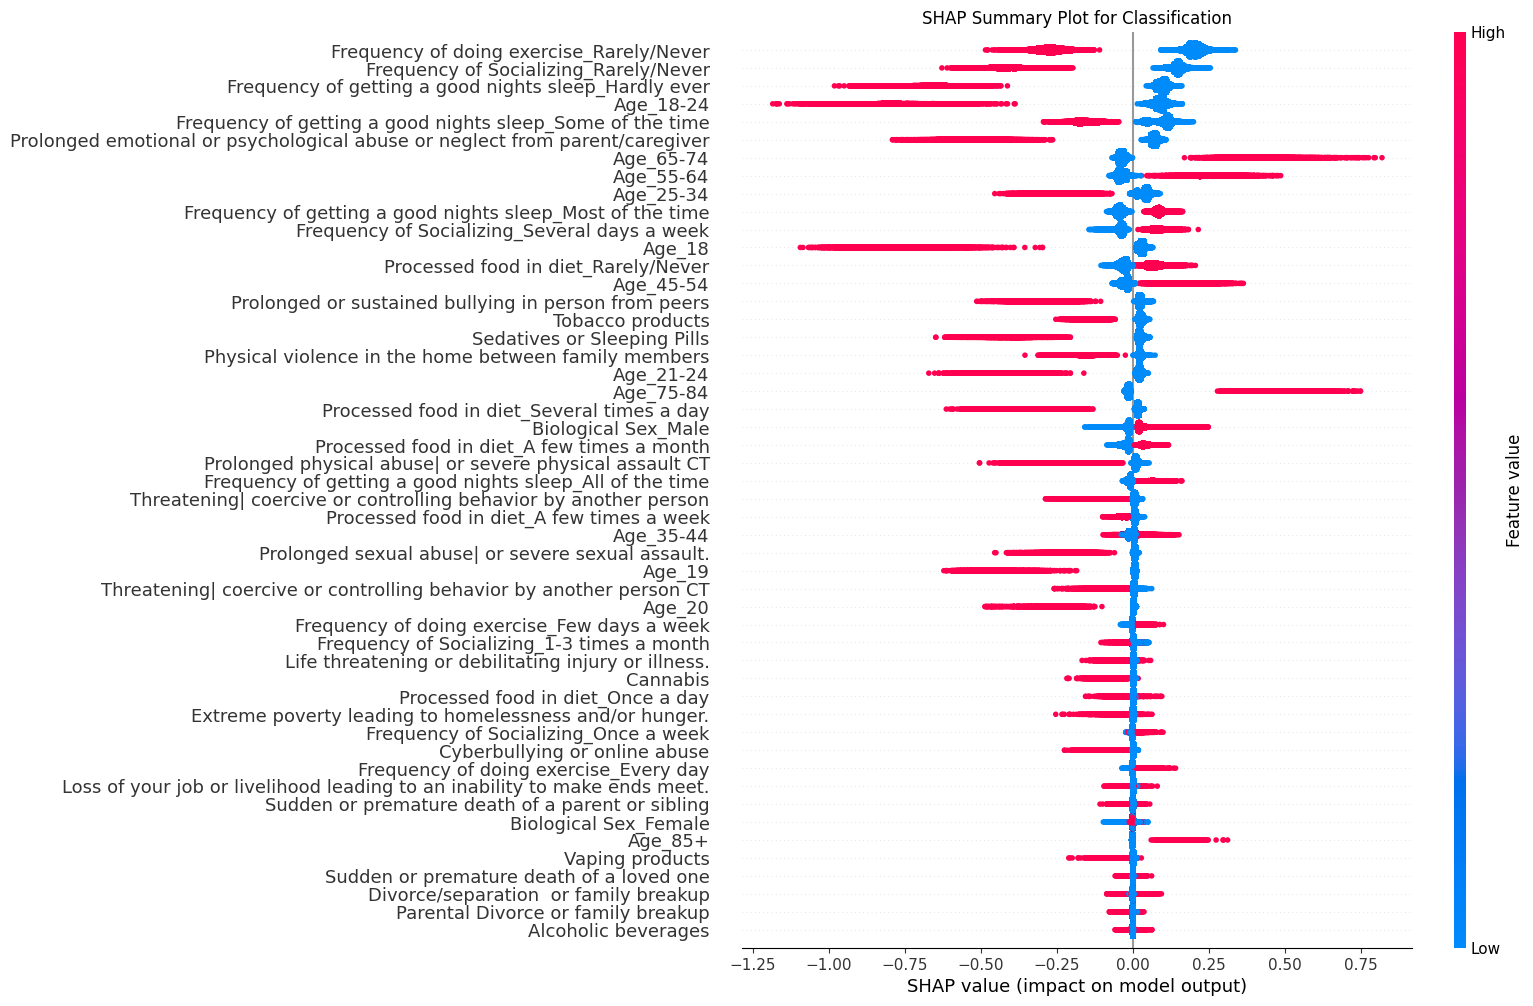

In [10]:

import matplotlib.pyplot as plt

# Specify the plot size directly in the SHAP summary_plot function
shap.summary_plot(shap_values_C, X_train, show=False, plot_size=(16,10), max_display=50)  # Adjust the size (width, height) as needed

plt.title(f'SHAP Summary Plot for Classification')
plt.show()

In [ ]:
# visualize the training set predictions
#  takes too long to run

import numpy as np

# Assuming shap_values_C is a numpy array
sampled_indices = np.random.choice(shap_values_C.shape[0], size=20000, replace=False)
sampled_shap_values_C = shap_values_C[sampled_indices]

shap.plots.force(sampled_shap_values_C)

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('Processed food in diet_Rarely/Never', shap_values_C.values, X_train, interaction_index="Frequency of Socializing_Rarely/Never")


In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_C,max_display=15)

In [ ]:
import shap
from shap import Explainer

shap.force_plot(
    shap.Explainer.expected_value[1], shap_values_C[1][:1000, :], X_train.iloc[:1000, :]
)

In [11]:
explainer_R = shap.Explainer(model_R)
shap_values_R = explainer_R(X_train_reg)


[11:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [ ]:
shap.plots.waterfall(shap_values[X_train])


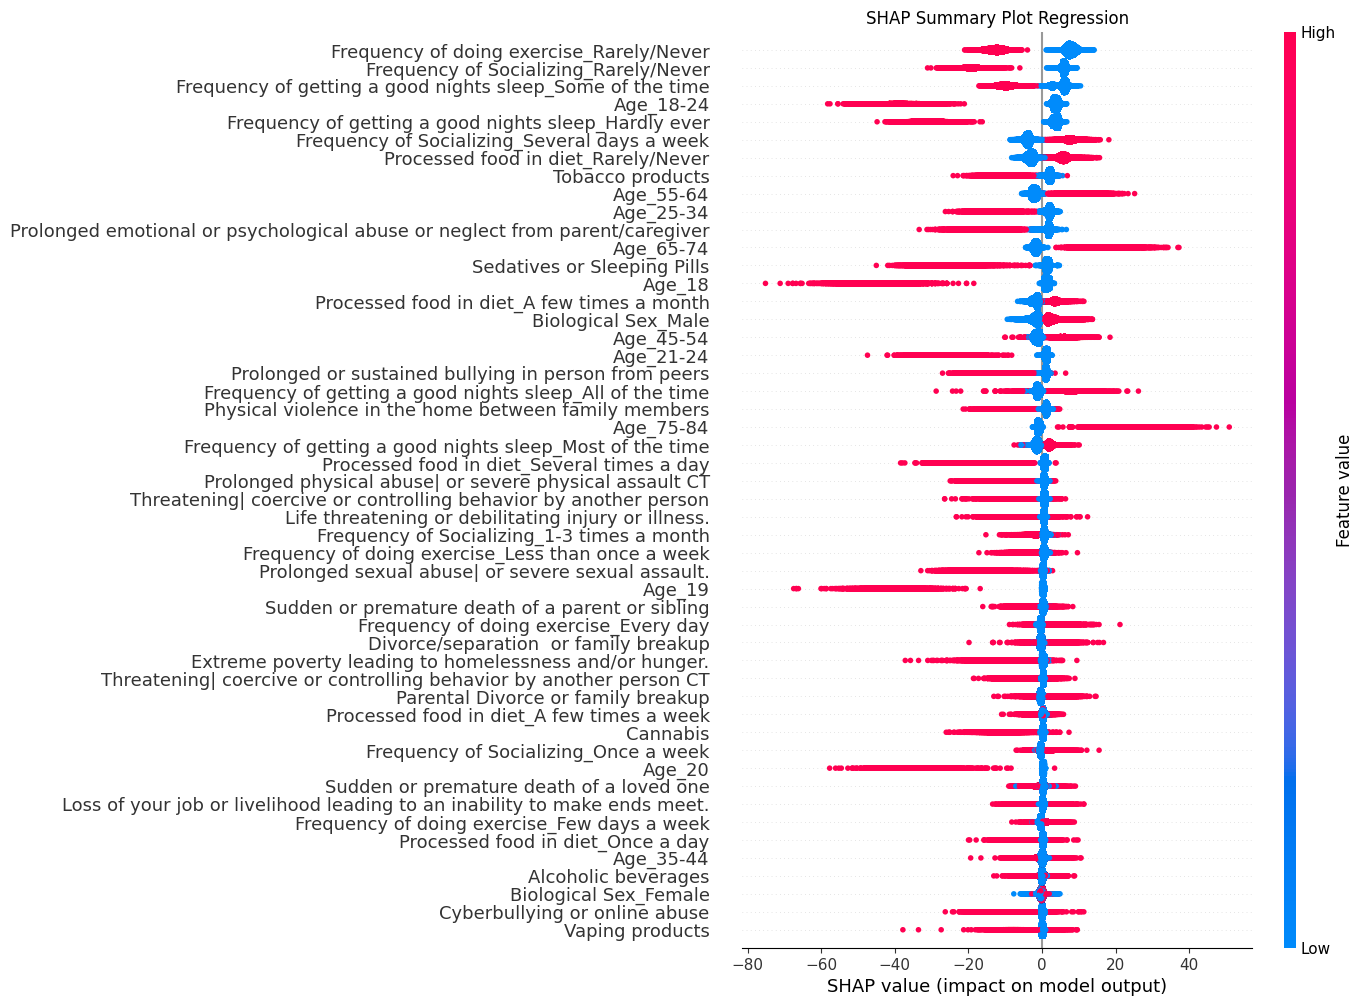

In [12]:
# Specify the plot size directly in the SHAP summary_plot function
shap.summary_plot(shap_values_R, X_train, show=False, plot_size=(14,10), max_display=50)  # Adjust the size (width, height) as needed

plt.title(f'SHAP Summary Plot Regression')
plt.show()

In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
import numpy as np

# Assuming 'df' is your DataFrame with X and Y
# Replace 'df' with the name of your DataFrame
# Ensure your target column is named 'target'

def calculate_information_gain(X,y):
  
    # Calculating mutual information
    mutual_info = mutual_info_classif(X, y)

    # Creating a DataFrame for easier visualization
    info_gain_df = pd.DataFrame(mutual_info, index=X.columns, columns=['Information Gain'])
    
    # Sorting the DataFrame based on information gain
    sorted_info_gain = info_gain_df.sort_values(by='Information Gain', ascending=False)

    return sorted_info_gain

#Example usage:
sorted_info_gain = calculate_information_gain(X,y)
print(sorted_info_gain)
